In [1]:
import numpy as np
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Load your dataset (here, using a smaller subset for demonstration)
with open('/kaggle/input/texts-dataset/texts.pkl', 'rb') as file:
    texts = pickle.load(file)
texts = texts[:15000]  # Use a subset for faster processing
print(f"Number of texts loaded: {len(texts)}")

Number of texts loaded: 15000


In [1]:
# Tokenize Text Data and Limit Vocabulary Size
tokenizer = Tokenizer(oov_token="<OOV>", num_words=10000)
tokenizer.fit_on_texts(texts)
vocab_size = len(tokenizer.word_index) + 1  # +1 for the padding index

# Generate input sequences for training
input_sequences = []
for line in texts:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Pad sequences to ensure uniform length
max_sequence_len = max(len(seq) for seq in input_sequences)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

# Split into inputs (X) and labels (y)
X, y = input_sequences[:, :-1], input_sequences[:, -1]
y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")
print(X_train.shape)
print(y_train.shape)

Number of texts loaded: 15000
Training samples: 127808, Validation samples: 31952
(127808, 71)
(127808, 8748)


In [25]:
embedding_dim = 100  # Dimension of word embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))  # Initialize an empty embedding matrix

# Use MirroredStrategy for multi-GPU setup
strategy = tf.distribute.MirroredStrategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")  # Prints 2 if two GPUs are available

# Start building and compiling the model within the strategy scope
with strategy.scope():
    # Build the Keras Model
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_sequence_len-1, trainable=True),
        LSTM(256, return_sequences=True),
        Dropout(0.2),
        LSTM(128, return_sequences=False),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dense(vocab_size, activation='softmax')  # Output layer (one for each word in the vocabulary)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


Number of devices: 2


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=128,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.0326 - loss: 6.7632 - val_accuracy: 0.0448 - val_loss: 6.1625
Epoch 2/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.0513 - loss: 6.0526 - val_accuracy: 0.0827 - val_loss: 5.8851
Epoch 3/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.0812 - loss: 5.7280 - val_accuracy: 0.1067 - val_loss: 5.6832
Epoch 4/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.1048 - loss: 5.4918 - val_accuracy: 0.1187 - val_loss: 5.5686
Epoch 5/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.1218 - loss: 5.2968 - val_accuracy: 0.1360 - val_loss: 5.4852
Epoch 6/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.1315 - loss: 5.1851 - val_accuracy: 0.1402 - val_loss: 5.4318
Epoch 7/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.1401 - loss: 5.0532 - val_accuracy: 0.1447 - val_loss: 5.3962
Epoch 8/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.1452 - loss: 4.9469 - 

In [8]:
# model.save('grp10_nextWord_1.keras')
# with open('training_history_model1.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

model = load_model('/kaggle/input/next-word-predictor_v1/keras/default/1/grp10_nextWord_1.keras')
with open('/kaggle/input/next-word-predictor_v1/keras/default/1/training_history_model1.pkl', 'rb') as f:
    history = pickle.load(f)

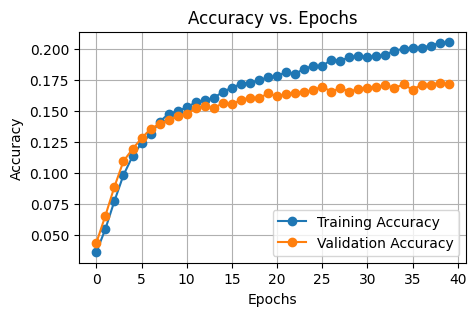

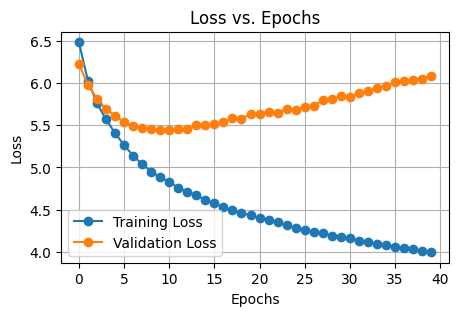

In [9]:
# 5. Plot Accuracy and Loss
import matplotlib.pyplot as plt
def plot_training_history(history):
    # Accuracy Plot
    plt.figure(figsize=(5, 3))
    plt.plot(history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title("Accuracy vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

    # Loss Plot
    plt.figure(figsize=(5, 3))
    plt.plot(history['loss'], label='Training Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='o')
    plt.title("Loss vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

plot_training_history(history)

In [7]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 71, 100)        │       874,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 71, 256)        │       365,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 71, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8748)           │     1,128,492 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,747,478 (29.55 MB)

 Trainable params: 2,582,492 (9.85 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,164,986 (19.70 MB)